"""

LLM Knowledge-Distillation Evaluation Suite
==========================================
Clean, modular code for evaluating a distilled student model family against a
teacher LLM.  Designed for use in a Jupyter notebook – simply copy each logical
section into its own cell, or run the entire script as a standalone job.

Key Features
------------
* **One-place configuration** for paths, batch size, temperature, etc.
* **Re-usable helper functions** (NLL, KL, cosine similarity, memorisation).
* **Plot helpers** that save IEEE-ready PNGs (no title) to `Evaluation Results/`
  while optionally displaying a titled version inside the notebook.
* **Automatic CSV export** of every results table.
* **Figure-size knobs**: set the global `FIGSIZE` or pass `figsize=(w,h)` to each
  plotting helper for quick tweaks.

Folder Layout
-------------
ROOT/
├── results/              # pre-trained student checkpoints  (student_model_*.pt)
└── Evaluation Results/   # created automatically - saves PNG & CSV outputs

"""

In [ ]:
# %% --------------------------- 1. Imports ------------------------------------
import math, os, warnings, itertools
from pathlib import Path
from collections import Counter, defaultdict

import torch, torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    GPT2Config,
    GPT2LMHeadModel,
)


e:\Research\LLM_Smashdown_Vega\my_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# %% --------------------------- 2. Global Config ------------------------------
ROOT            = Path(".")      # project root
RESULT_DIR      = ROOT / "results"                    # student checkpoints
EVAL_DIR        = ROOT / "Evaluation Results"          # outputs (created)
EVAL_DIR.mkdir(parents=True, exist_ok=True)

STUDENT_LAYERS  = [4, 5, 6, 7, 8]      # checkpoints to evaluate
BATCH_SIZE      = 8                    # eval micro-batch
SUBSET_LINES    = 1_000                # None → full WikiText-2 test split
KL_TEMP         = 1.0                  # distillation temperature for KL
MAX_LEN         = 128                  # must match training
FIGSIZE         = (7, 4)               # default plot size (overwrite as needed)
SEABORN_PALETTE = "crest"              # colour palette
SAVE_DPI        = 800

# Runtime toggles (set False if short on GPU time)
RUN_MEMORISATION     = True    # Carlini-style k-gram extraction
RUN_PROB_ALIGNMENT   = True

sns.set_style("whitegrid")
warnings.filterwarnings("ignore", category=UserWarning, module="datasets")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


In [3]:
# %% --------------------------- 3. Teacher Model ------------------------------
TEACHER_NAME = "distilgpt2"

tokenizer = AutoTokenizer.from_pretrained(TEACHER_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

teacher = AutoModelForCausalLM.from_pretrained(TEACHER_NAME).to(device).eval()
print(f"Teacher loaded - {teacher.config.n_layer} layers")



Teacher loaded - 6 layers


In [4]:
# %% --------------------------- 4. Dataset (WikiText-2) -----------------------
print("Loading WikiText-2 test …")
wt2_test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
if SUBSET_LINES is not None:
    wt2_test = wt2_test.select(range(min(SUBSET_LINES, len(wt2_test))))
print("Eval lines:", len(wt2_test))

def _tok(ex):
    return tokenizer(ex["text"], truncation=True, padding="max_length", max_length=MAX_LEN)

wt2_tok = wt2_test.map(_tok, batched=True)
wt2_tok.set_format(type="torch", columns=["input_ids", "attention_mask"])
wt2_loader = DataLoader(wt2_tok, batch_size=BATCH_SIZE)


Loading WikiText-2 test …
Eval lines: 1000


In [5]:
# %% --------------------------- 5. Helper Functions ---------------------------
@torch.no_grad()
def tokenwise_nll(model, loader):
    tot, ntok = 0.0, 0
    for batch in loader:
        batch = {k:v.to(device) for k,v in batch.items()}
        out   = model(**batch, labels=batch["input_ids"])
        tot  += out.loss.item()*batch["input_ids"].numel()
        ntok += batch["input_ids"].numel()
    return tot/ntok

@torch.no_grad()
def kl_to_teacher(student, teacher, loader, T=1.0):
    tot, ntok = 0.0, 0
    for batch in loader:
        batch = {k:v.to(device) for k,v in batch.items()}
        t = teacher(**batch).logits/T
        s = student (**batch).logits/T
        kl = F.kl_div(F.log_softmax(s, -1), F.softmax(t, -1), reduction="batchmean")
        tot  += kl.item()*batch["input_ids"].numel()
        ntok += batch["input_ids"].numel()
    return tot/ntok

def load_student(L):
    ckpt = RESULT_DIR/f"student_model_{L}.pt"
    if not ckpt.exists():
        raise FileNotFoundError(ckpt)
    cfg = GPT2Config(
        vocab_size=tokenizer.vocab_size,
        n_positions=MAX_LEN,
        n_ctx=MAX_LEN,
        n_embd=teacher.config.n_embd,
        n_layer=L,
        n_head=teacher.config.n_head,
    )
    stu = GPT2LMHeadModel(cfg)
    with torch.no_grad():
        stu.transformer.wte.weight.copy_(teacher.transformer.wte.weight)
        stu.lm_head.weight.copy_(teacher.lm_head.weight)
    stu.load_state_dict(torch.load(ckpt, map_location="cpu"))
    return stu.to(device).eval()

# --- utility: fig saver -------------------------------------------------------

def save_fig(fig: plt.Figure, stem: str, ieee: bool=True, show: bool=True):
    orig_titles = [ax.get_title() for ax in fig.axes]
    if ieee:
        for ax in fig.axes: ax.set_title("")
    fig.savefig(EVAL_DIR/f"{stem}.pdf", dpi=SAVE_DPI, bbox_inches="tight")
    if ieee:
        for ax,t in zip(fig.axes, orig_titles): ax.set_title(t)
    if show: plt.show();
    else: plt.close(fig)

# --- utility: wide table export ----------------------------------------------

def export_table(df_long: pd.DataFrame, index: str, columns: str, values: str, name: str):
    wide = df_long.pivot(index=index, columns=columns, values=values)
    wide.to_csv(EVAL_DIR/f"{name}.csv")
    display(wide.round(3))
    print(f"→ CSV saved: {name}.csv")
    

In [6]:
# %% --------------------------- 6. Core Evaluation ---------------------------
rows = []
print("Evaluating teacher …")
teacher_nll = tokenwise_nll(teacher, wt2_loader)
rows.append({"Model":"Teacher","Layers":teacher.config.n_layer,"NLL":teacher_nll,
             "Perplexity":math.exp(teacher_nll),"KL":0.0})
for L in STUDENT_LAYERS:
    print(f"Student_{L} …")
    stu = load_student(L)
    nll = tokenwise_nll(stu, wt2_loader)
    kl  = kl_to_teacher(stu, teacher, wt2_loader, T=KL_TEMP)
    rows.append({"Model":f"Student_{L}","Layers":L,"NLL":nll,
                 "Perplexity":math.exp(nll),"KL":kl})
    del stu; torch.cuda.empty_cache()
metric_df = pd.DataFrame(rows).sort_values("Layers").reset_index(drop=True)
metric_df.to_csv(EVAL_DIR/"wikitext2_metrics.csv", index=False)
print("→ Metrics table saved")

display(metric_df)


Evaluating teacher …


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Student_4 …
Student_5 …
Student_6 …
Student_7 …
Student_8 …
→ Metrics table saved


Model  Layers       NLL   Perplexity         KL
0  Student_4       4  7.607615  2013.470612  19.256749
1  Student_5       5  7.592086  1982.443839  17.315876
2    Teacher       6  7.509718  1825.698119   0.000000
3  Student_6       6  7.580443  1959.496548  15.658727
4  Student_7       7  7.561503  1922.733039  14.367247
5  Student_8       8  7.570491  1940.092302  13.922844

C:\Users\gharamik\AppData\Local\Temp\ipykernel_26872\124522239.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  fig,ax=plt.subplots(); sns.lineplot(data=metric_df,x="Layers",y="Perplexity",marker="o",ax=ax,palette=palette)


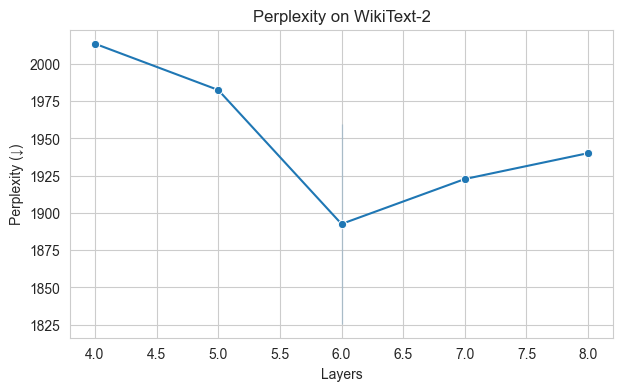

C:\Users\gharamik\AppData\Local\Temp\ipykernel_26872\124522239.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  fig,ax=plt.subplots(); sns.lineplot(data=metric_df,x="Layers",y="KL",marker="o",ax=ax,palette=palette)


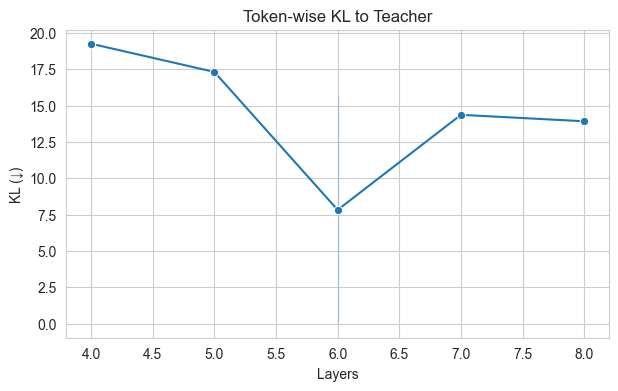

In [ ]:
# %% --------------------------- 7. Plots (Per-layer) --------------------------
plt.rcParams.update({"figure.figsize":FIGSIZE})
palette = sns.color_palette(SEABORN_PALETTE, len(metric_df))

fig,ax=plt.subplots(); sns.lineplot(data=metric_df,x="Layers",y="Perplexity",marker="o",ax=ax,palette=palette)
ax.set_title("Perplexity on WikiText-2")
ax.set_ylabel("Perplexity (↓)"); save_fig(fig,"perplexity_vs_layers")

fig,ax=plt.subplots(); sns.lineplot(data=metric_df,x="Layers",y="KL",marker="o",ax=ax,palette=palette)
ax.set_title("Token-wise KL to Teacher"); ax.set_ylabel("KL (↓)"); save_fig(fig,"kl_vs_layers")


Generating probability‑alignment scatter plots …


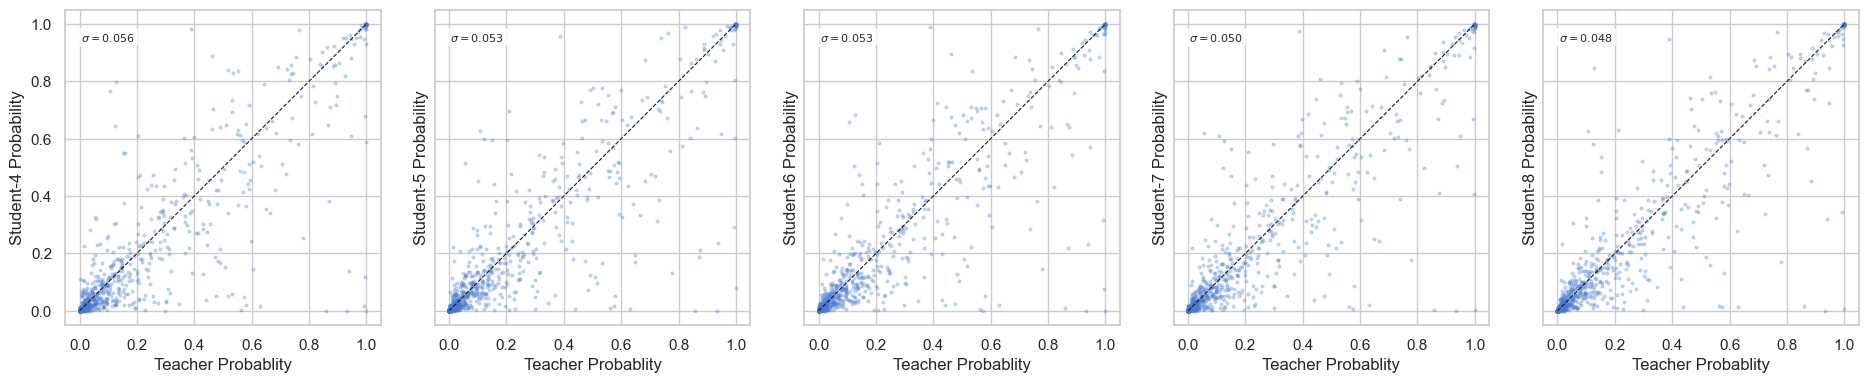

In [ ]:
# %% --------------------------- 8. Probability Alignment ----------------------
if RUN_PROB_ALIGNMENT:
    print("Generating probability-alignment scatter plots …")

    def _gt_probs(batch, logits):
        """Return P(gt_token) for each position (batch × seq-1)."""
        gt    = batch["input_ids"][:, 1:]
        probs = torch.softmax(logits[:, :-1], -1)
        rows  = torch.arange(gt.size(0)).unsqueeze(-1)
        cols  = torch.arange(gt.size(1)).unsqueeze(0)
        return probs[rows, cols, gt]

    def scatter_one(model, label, ax, max_pts=5_000):
        xs, ys = [], []
        with torch.no_grad():
            for batch in wt2_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                t_log, s_log = teacher(**batch).logits, model(**batch).logits
                xs.extend(_gt_probs(batch, t_log).cpu().ravel().tolist())
                ys.extend(_gt_probs(batch, s_log).cpu().ravel().tolist())
                if len(xs) >= max_pts:
                    break

        xs, ys = np.array(xs[:max_pts]), np.array(ys[:max_pts])
        ax.scatter(xs, ys, s=4, alpha=.25)
        ax.plot([0, 1], [0, 1], 'k--', lw=.8)

        # axis labels ---------------------------------------------------------
        ax.set_xlabel("Teacher Probablity")
        ax.set_ylabel(f"{label.replace('_', '-')} Probability")   # e.g. “Student-4 P”

        # σ annotation --------------------------------------------------------
        sigma = np.std(ys - xs)
        ax.text(0.05, 0.90, rf"$\sigma={sigma:.3f}$",
                transform=ax.transAxes, fontsize=8,
                bbox=dict(boxstyle="round,pad=0.25",
                          facecolor="white", alpha=0.8))

    # ------ five-in-a-row layout --------------------------------------------
    cols, rows = len(STUDENT_LAYERS), 1
    fig, axes  = plt.subplots(rows, cols,
                              figsize=(cols * 3.8, 3.8),
                              sharex=True, sharey=True,
                              subplot_kw={"aspect": "equal"})
    axes = axes.flatten()

    for ax, L in zip(axes, STUDENT_LAYERS):
        scatter_one(load_student(L), f"Student_{L}", ax)

    # fig.suptitle("Probability alignment with Teacher (GT token prob.)", y=1.05)
    plt.tight_layout()
    save_fig(fig, "prob_alignment")   # IEEE-ready PNG in Evaluation Results/


Generating probability‑alignment scatter plots …


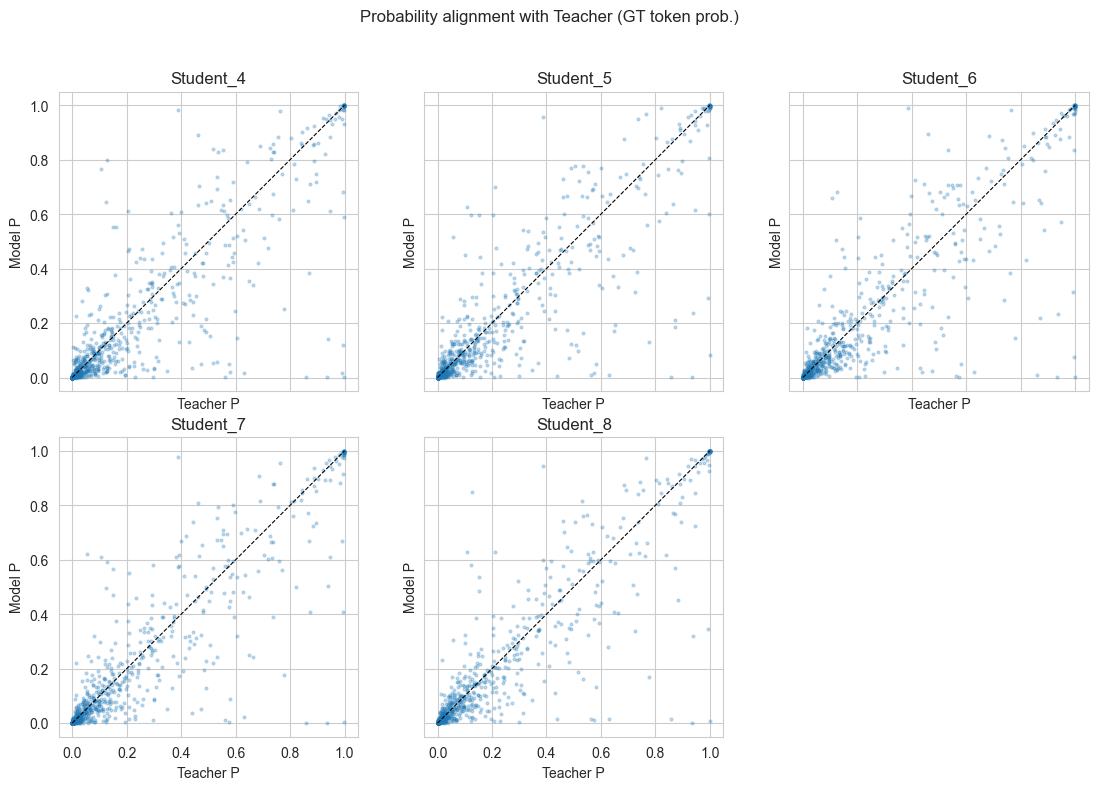

In [ ]:
# %% --------------------------- 8. Probability Alignment ----------------------
if RUN_PROB_ALIGNMENT:
    print("Generating probability-alignment scatter plots …")
    def sample_gt_prob(batch, logits):
        gt = batch["input_ids"][:,1:]
        probs = torch.softmax(logits[:,:-1], -1)
        rows = torch.arange(gt.size(0)).unsqueeze(-1)
        cols = torch.arange(gt.size(1)).unsqueeze(0)
        return probs[rows, cols, gt]
    def scatter_one(model, label, ax, max_pts=5000):
        xs, ys = [], []
        with torch.no_grad():
            for batch in wt2_loader:
                batch = {k:v.to(device) for k,v in batch.items()}
                t_logits = teacher(**batch).logits
                s_logits = model  (**batch).logits
                xs.extend(sample_gt_prob(batch,t_logits).cpu().flatten().tolist())
                ys.extend(sample_gt_prob(batch,s_logits).cpu().flatten().tolist())
                if len(xs)>=max_pts: break
        ax.scatter(xs[:max_pts], ys[:max_pts], s=4, alpha=.25)
        ax.plot([0,1],[0,1],'k--',lw=.8); ax.set_title(label,fontsize=9)
        ax.set_xlabel("Teacher P"); ax.set_ylabel("Model P")
    cols = 3; rows = math.ceil(len(STUDENT_LAYERS)/cols)
    fig,axes=plt.subplots(rows,cols,figsize=(cols*3.8,rows*3.8),sharex=True,sharey=True,subplot_kw={"aspect":"equal"})
    axes=axes.flatten()
    for i,(L,ax) in enumerate(zip(STUDENT_LAYERS,axes)):
        scatter_one(load_student(L),f"Student_{L}",ax)
    for j in range(i+1,len(axes)): fig.delaxes(axes[j])
    fig.suptitle("Probability alignment with Teacher (GT token prob.)",y=1.03)
    plt.tight_layout(); save_fig(fig,"prob_alignment")
    

KL by token‑frequency bucket …


C:\Users\gharamik\AppData\Local\Temp\ipykernel_26872\2393703498.py:27: RuntimeWarning: invalid value encountered in divide
  return tot/cnt


Bucket     High‑freq  Low‑freq    Mid  Most common  Rarest
Model                                                     
Student_4      0.431       NaN  0.500        0.357     NaN
Student_5      0.387       NaN  0.473        0.319     NaN
Student_6      0.356       NaN  0.426        0.288     NaN
Student_7      0.321       NaN  0.403        0.264     NaN
Student_8      0.313       NaN  0.395        0.255     NaN
Teacher        0.000       0.0  0.000        0.000     0.0

→ CSV saved: bucket_kl_wide.csv


C:\Users\gharamik\AppData\Local\Temp\ipykernel_26872\2490986287.py:49: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.savefig(EVAL_DIR/f"{stem}.pdf", dpi=SAVE_DPI, bbox_inches="tight")
e:\Research\LLM_Smashdown_Vega\my_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


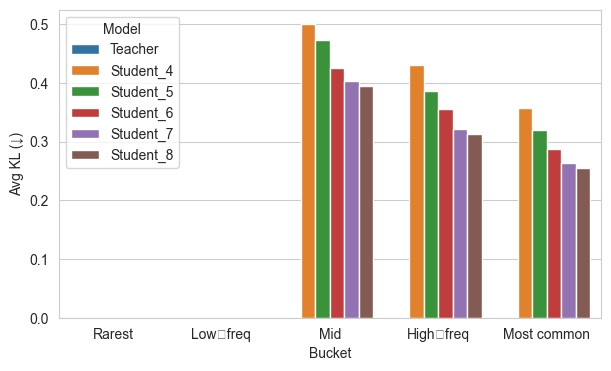

In [ ]:
# %% --------------------------- 9. Bucket KL (token freq) ---------------------
print("KL by token-frequency bucket …")

def build_freq_map(ds,n=5):
    cnt=Counter();
    for ids in ds["input_ids"]: cnt.update(ids.tolist())
    total=sum(cnt.values()); freq={t:c/total for t,c in cnt.items()};
    qs=np.quantile(list(freq.values()), np.linspace(0,1,n+1))
    return {tok:min(np.searchsorted(qs,p,"right")-1,n-1) for tok,p in freq.items()}

freq_map = build_freq_map(wt2_tok, n=5)
labels=["Rarest","Low-freq","Mid","High-freq","Most common"]

@torch.no_grad()
def bucket_kl(stu,nbuck=5):
    tot=np.zeros(nbuck); cnt=np.zeros(nbuck); pad=tokenizer.pad_token_id
    for batch in wt2_loader:
        batch={k:v.to(device) for k,v in batch.items()}
        t=teacher(**batch).logits/ KL_TEMP; s=stu(**batch).logits/ KL_TEMP
        kl=F.kl_div(F.log_softmax(s,-1),F.softmax(t,-1),reduction="none").sum(-1)
        ids=batch["input_ids"]
        for row_ids,row_kl in zip(ids,kl):
            for tok,klval in zip(row_ids,row_kl):
                if tok.item()==pad: continue
                b=freq_map.get(int(tok),0)
                tot[b]+=klval.item(); cnt[b]+=1
    return tot/cnt

bucket_rows=[{"Model":"Teacher","Bucket":lab,"KL":0.0} for lab in labels]
for L in STUDENT_LAYERS:
    stu=load_student(L); vals=bucket_kl(stu); del stu
    bucket_rows.extend([{"Model":f"Student_{L}","Bucket":lab,"KL":val} for lab,val in zip(labels,vals)])
    torch.cuda.empty_cache()

bucket_long=pd.DataFrame(bucket_rows)
export_table(bucket_long,"Model","Bucket","KL","bucket_kl_wide")
fig,ax=plt.subplots(); sns.barplot(data=bucket_long,x="Bucket",y="KL",hue="Model",ax=ax)
ax.set_ylabel("Avg KL (↓)"); save_fig(fig,"bucket_kl")


Size vs perplexity …


Model     Params   Perplexity
0  Student_4  67.048704  2013.470612
1  Student_5  74.136576  1982.443839
2  Student_6  81.224448  1825.698119
3  Student_7  88.312320  1922.733039
4  Student_8  95.400192  1940.092302

C:\Users\gharamik\AppData\Local\Temp\ipykernel_26872\2490986287.py:49: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.savefig(EVAL_DIR/f"{stem}.pdf", dpi=SAVE_DPI, bbox_inches="tight")
e:\Research\LLM_Smashdown_Vega\my_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


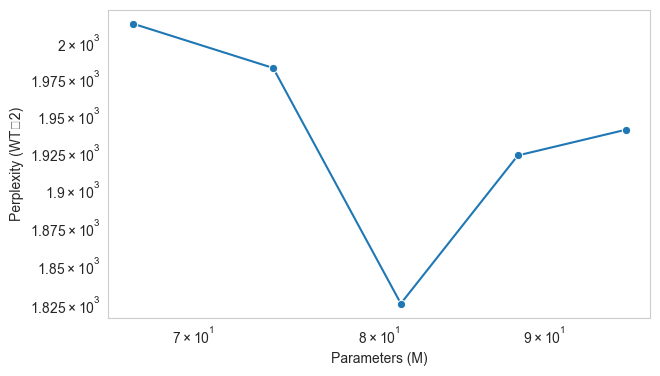

In [ ]:
# %% --------------------------- 10. Size vs Perplexity ------------------------
print("Size vs perplexity …")

def nparams(m): return sum(p.numel() for p in m.parameters())/1e6
size_rows=[]
for L in STUDENT_LAYERS:
    stu=load_student(L); size_rows.append({"Model":f"Student_{L}","Params":nparams(stu),
        "Perplexity":metric_df.loc[metric_df.Layers==L,"Perplexity"].values[0]}); del stu
size_df=pd.DataFrame(size_rows)
size_df.to_csv(EVAL_DIR/"size_vs_ppl.csv",index=False); display(size_df)
fig,ax=plt.subplots(); sns.lineplot(data=size_df,x="Params",y="Perplexity",marker="o",ax=ax)
ax.set_xscale("log"); ax.set_yscale("log"); ax.set_xlabel("Parameters (M)");
ax.set_ylabel("Perplexity (WT-2)"); save_fig(fig,"size_vs_ppl")


Computing hidden-state cosine similarity …


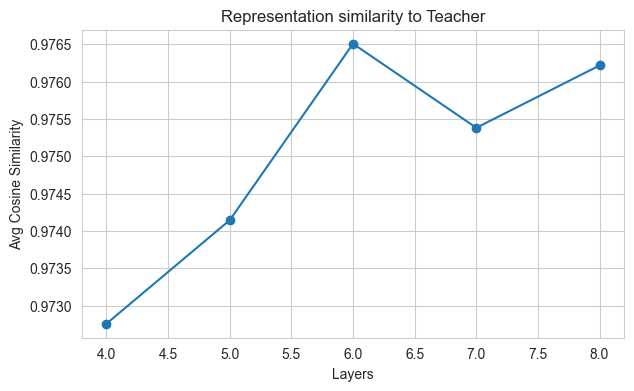

In [12]:
# %% --------------------------- 11. Cosine Similarity -------------------------
print("Computing hidden-state cosine similarity …")

@torch.no_grad()
def hidden_cosine(student, teacher, loader, nsent=500):
    cos = torch.nn.CosineSimilarity(-1)
    sims = []
    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        t_h = teacher.transformer(**batch).last_hidden_state
        s_h = student .transformer(**batch).last_hidden_state
        sims.extend(cos(t_h, s_h).mean(-1).flatten().cpu().tolist())
        if len(sims) > nsent:
            break
    return np.mean(sims)

cos_scores = {L: hidden_cosine(load_student(L), teacher, wt2_loader) for L in STUDENT_LAYERS}
cos_df = pd.DataFrame({"Layers": list(cos_scores.keys()), "Cosine": list(cos_scores.values())})
cos_df.to_csv(EVAL_DIR / "hidden_cosine.csv", index=False)

fig, ax = plt.subplots()
ax.plot(cos_df["Layers"], cos_df["Cosine"], marker="o")
ax.set_xlabel("Layers"); ax.set_ylabel("Avg Cosine Similarity")
ax.set_title("Representation similarity to Teacher")
save_fig(fig, "hidden_cosine")


Running k-gram memorisation analysis - this may take a while …


Teacher:   0%|          | 0/2000 [00:00<?, ?it/s]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Teacher:   0%|          | 1/2000 [00:01<58:25,  1.75s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Teacher:   0%|          | 2/2000 [00:03<49:03,  1.47s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavio

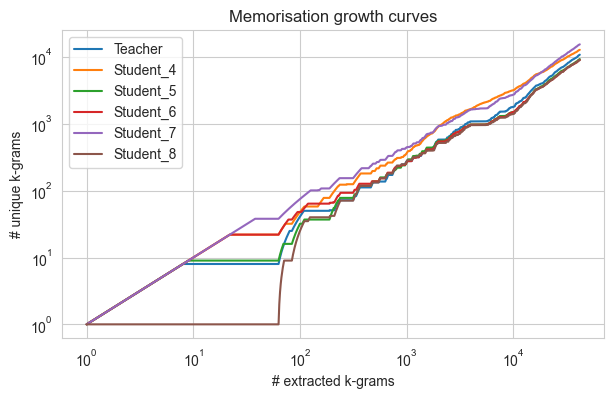

Model     Params  Unique
0    Teacher  81.912576   10845
1  Student_4  67.048704   12828
2  Student_5  74.136576    9318
3  Student_6  81.224448    9035
4  Student_7  88.312320   15486
5  Student_8  95.400192    9015

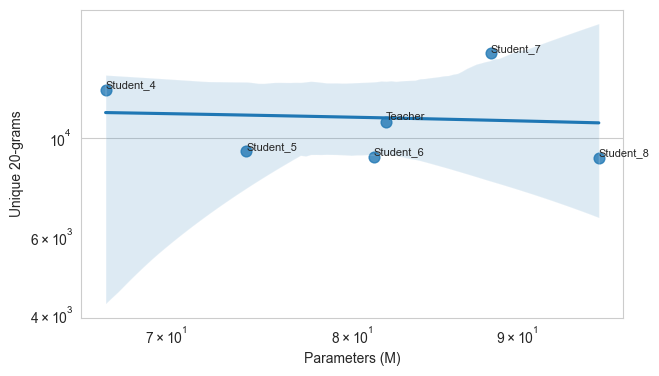


All evaluations complete   results in Evaluation Results


In [13]:
# %% --------------------------- 12 Memorisation (Carlini et al.) -------------
if RUN_MEMORISATION:
    print("Running k-gram memorisation analysis - this may take a while …")
    K=20; N_PROMPTS=2_000; PROMPT_LEN=30; GEN_LEN=40
    prompt_ds=load_dataset("wikitext","wikitext-2-raw-v1",split="train").select(range(N_PROMPTS))
    prompts_tok=[tokenizer(r["text"],add_special_tokens=False).input_ids[:PROMPT_LEN] or [tokenizer.eos_token_id] for r in prompt_ds]
    def kgrams(seq,k=K): return [tuple(seq[i:i+k]) for i in range(len(seq)-k+1)]
    extracted=defaultdict(list); stats={}
    def run_model(model,name):
        grams=[]; uniq=[]; model.eval()
        with torch.no_grad():
            for p in tqdm(prompts_tok,desc=name):
                out=model.generate(torch.tensor([p]).to(device),max_length=PROMPT_LEN+GEN_LEN,do_sample=False)
                gen=out[0,PROMPT_LEN:].tolist()
                for kg in kgrams(gen,K):
                    grams.append(kg); uniq.append(len(set(grams)))
        extracted[name]=grams
        stats[name]=pd.DataFrame({"total":np.arange(1,len(grams)+1),"unique":uniq})
    run_model(teacher,"Teacher")
    for L in STUDENT_LAYERS:
        run_model(load_student(L),f"Student_{L}"); torch.cuda.empty_cache()

    fig,ax=plt.subplots();
    for k,df in stats.items(): ax.plot(df.total,df.unique,label=k)
    ax.set_xscale("log"); ax.set_yscale("log"); ax.set_xlabel("# extracted k-grams");
    ax.set_ylabel("# unique k-grams"); ax.set_title("Memorisation growth curves"); ax.legend()
    save_fig(fig,"memorisation_growth")

    # size vs mem
    mem_rows=[{"Model":m,"Params":nparams(teacher) if m=="Teacher" else nparams(load_student(int(m.split("_")[1]))),"Unique":len(set(v))} for m,v in extracted.items()]
    mem_df=pd.DataFrame(mem_rows)
    mem_df.to_csv(EVAL_DIR/"size_vs_mem.csv",index=False); display(mem_df)
    fig,ax=plt.subplots(); sns.regplot(data=mem_df,x="Params",y="Unique",scatter_kws=dict(s=60,alpha=.8),ax=ax)
    for _,r in mem_df.iterrows(): ax.text(r.Params,r.Unique,r.Model,fontsize=8,va="bottom")
    ax.set_xscale("log"); ax.set_yscale("log"); ax.set_xlabel("Parameters (M)");
    ax.set_ylabel(f"Unique {K}-grams"); save_fig(fig,"size_vs_mem")

print("\nAll evaluations complete   results in",EVAL_DIR)

In [22]:
# %% --------------------------- 13.  Summary Metrics --------------------------
print("Building relative performance table …")

# -- helpers ------------------------------------------------------------------
def nparams(model):                       # #parameters in millions
    return sum(p.numel() for p in model.parameters()) / 1_000_000

@torch.no_grad()
def throughput(model, loader, warmup=5, steps=20):
    """Simple tokens/sec benchmark on fwd‑pass."""
    import time, torch
    model.eval()
    tot_tok, tot_t = 0, 0.0
    for i, batch in enumerate(loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        if i == warmup:  torch.cuda.synchronize(); t0 = time.time()
        if i >= warmup + steps: break
        _ = model(**batch)
        tot_tok += batch["input_ids"].numel()
    torch.cuda.synchronize(); t1 = time.time()
    return tot_tok / (t1 - t0)

# -- teacher reference --------------------------------------------------------
teacher_params   = nparams(teacher)
teacher_speed    = throughput(teacher, wt2_loader)
teacher_kgrams   = set(extracted["Teacher"])            # from Section 12
teacher_k_unique = len(teacher_kgrams)

# -- build rows ---------------------------------------------------------------
rows = []
for L in STUDENT_LAYERS:
    name        = f"Student_{L}"
    stu         = load_student(L)                       # already on  GPU
    s_params    = nparams(stu)
    s_speed     = throughput(stu, wt2_loader)
    s_kgrams    = set(extracted[name])
    mem_match   = 100 * len(s_kgrams & teacher_kgrams) / teacher_k_unique
    speedup_ratio = s_speed / teacher_speed
    rows.append({
        "Model"       : name.replace('_', '-'),
        "Layers"      : L,
        "Mem match (%)": round(mem_match, 1),
        "Speed up (x)" : round(s_speed / teacher_speed, 2),
        "Speed up (%)"  : round(100 * (speedup_ratio - 1), 1),  # ← NEW COLUMN
        "Params ↓ (%)": round(100 * (teacher_params - s_params) / teacher_params, 1)
    })
    del stu; torch.cuda.empty_cache()

summary_df = pd.DataFrame(rows).sort_values("Layers").reset_index(drop=True)
display(summary_df)

# save CSV for LaTeX / paper
summary_df.to_csv(EVAL_DIR / "summary_relative_metrics.csv", index=False)
print("→ CSV saved: summary_relative_metrics.csv")


Building relative performance table …


Model  Layers  Mem match (%)  Speed up (x)  Speed up (%)  Params ↓ (%)
0  Student-4       4            1.8          1.19          18.7          18.1
1  Student-5       5            1.4          1.03           2.5           9.5
2  Student-6       6            1.1          0.97          -3.1           0.8
3  Student-7       7            0.5          0.88         -12.3          -7.8
4  Student-8       8            1.1          0.67         -33.2         -16.5

→ CSV saved: summary_relative_metrics.csv



📊 AIC and AICc Summary Table
       Model  Params_M  NLL_avg          AIC        AICc   Delta_AIC  \
0  Student-4      67.0     7.61  135947648.0  1691157.99         0.0   
1  Student-5      74.1     7.59  150143552.0  1687109.03  14195904.0   
2  Student-6      81.2     7.58  164340480.0  1684075.82  28392832.0   
3  Student-7      88.3     7.56  178535872.0  1679500.37  42588224.0   
4  Student-8      95.4     7.57  192738176.0  1681832.06  56790528.0   

   Delta_AICc  
0    11657.63  
1     7608.66  
2     4575.45  
3        0.00  
4     2331.70  


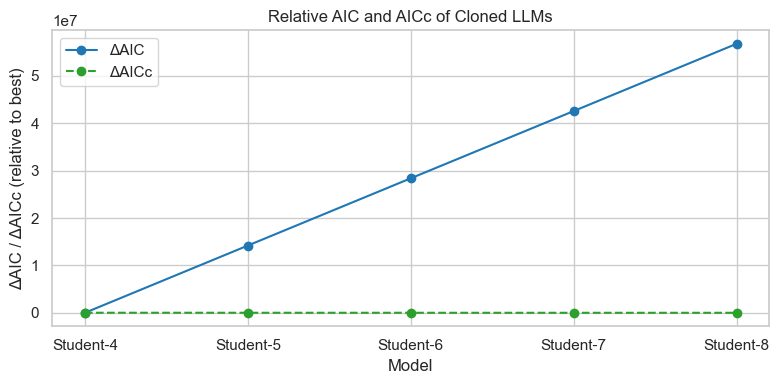

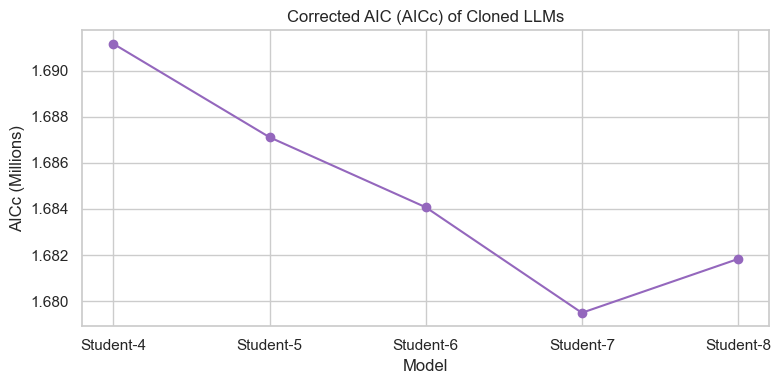

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# === Step 1: Input your Table I data ===
data = {
    "Model": ["Student-4", "Student-5", "Student-6", "Student-7", "Student-8"],
    "Params_M": [67.0, 74.1, 81.2, 88.3, 95.4],         # in millions
    "NLL_avg": [7.608, 7.592, 7.580, 7.562, 7.571],      # per-token NLL
}

df = pd.DataFrame(data)

# === Step 2: Constants ===
N_TOKENS = 128_000  # sample size n
df["Params"] = df["Params_M"] * 1_000_000
df["NLL_total"] = df["NLL_avg"] * N_TOKENS

# === Step 3: AIC Calculation ===
df["AIC"] = 2 * df["Params"] + 2 * df["NLL_total"]

# === Step 4: AICc Calculation ===
df["AICc"] = df["AIC"] + (2 * df["Params"] * (df["Params"] + 1)) / (N_TOKENS - df["Params"] - 1)

# === Step 5: ΔAIC & ΔAICc Calculation ===
df["Delta_AIC"] = df["AIC"] - df["AIC"].min()
df["Delta_AICc"] = df["AICc"] - df["AICc"].min()

# === Step 6: Display table ===
print("\n📊 AIC and AICc Summary Table")
print(df[["Model", "Params_M", "NLL_avg", "AIC", "AICc", "Delta_AIC", "Delta_AICc"]].round(2))

# === Step 7: Plot ΔAIC ===
plt.figure(figsize=(8, 4))
plt.plot(df["Model"], df["Delta_AIC"], marker="o", linestyle="-", color="tab:blue", label="ΔAIC")
plt.plot(df["Model"], df["Delta_AICc"], marker="o", linestyle="--", color="tab:green", label="ΔAICc")
plt.ylabel("ΔAIC / ΔAICc (relative to best)")
plt.xlabel("Model")
plt.title("Relative AIC and AICc of Cloned LLMs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("delta_aic_aicc_plot.pdf", dpi=600)
plt.show()

# === Step 8: Optional — Raw AICc plot in millions ===
plt.figure(figsize=(8, 4))
plt.plot(df["Model"], df["AICc"] / 1e6, marker="o", linestyle="-", color="tab:purple")
plt.ylabel("AICc (Millions)")
plt.xlabel("Model")
plt.title("Corrected AIC (AICc) of Cloned LLMs")
plt.grid(True)
plt.tight_layout()
plt.savefig("aicc_plot.pdf", dpi=600)
plt.show()


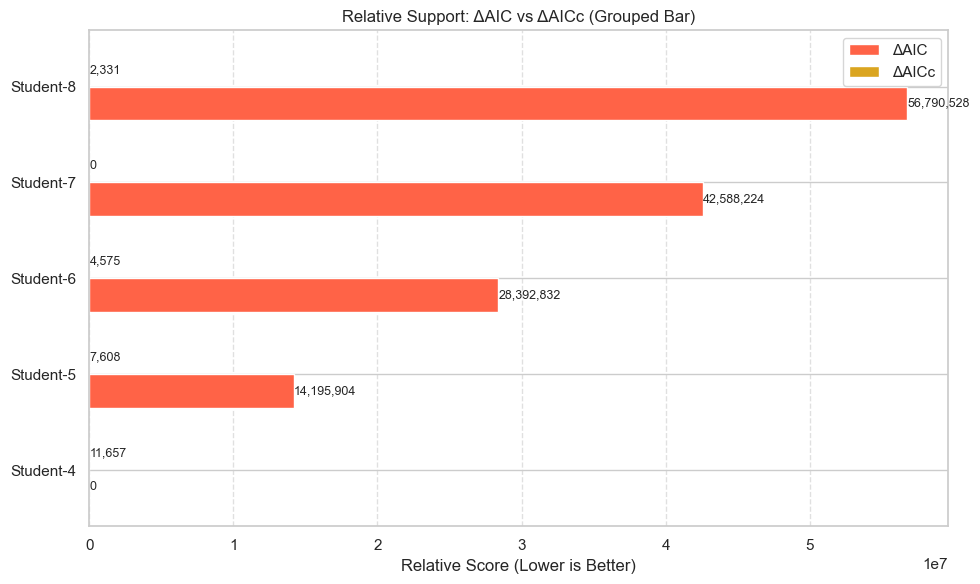

In [40]:
# Grouped bar for ΔAIC and ΔAICc
df_plot = df.copy()
bar_width = 0.35
indices = np.arange(len(df_plot))

plt.figure(figsize=(10, 6))
plt.barh(indices, df_plot["Delta_AIC"], bar_width, label="ΔAIC", color="tomato")
plt.barh(indices + bar_width, df_plot["Delta_AICc"], bar_width, label="ΔAICc", color="goldenrod")

for i, (daic, daicc) in enumerate(zip(df_plot["Delta_AIC"], df_plot["Delta_AICc"])):
    plt.text(daic + 10000, i, f"{int(daic):,}", va='center', fontsize=9)
    plt.text(daicc + 10000, i + bar_width, f"{int(daicc):,}", va='center', fontsize=9)

plt.yticks(indices + bar_width / 2, df_plot["Model"])
plt.xlabel("Relative Score (Lower is Better)")
plt.title("Relative Support: ΔAIC vs ΔAICc (Grouped Bar)")
plt.legend(loc="upper right")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("grouped_bar_delta_aic.pdf", dpi=600)
plt.show()



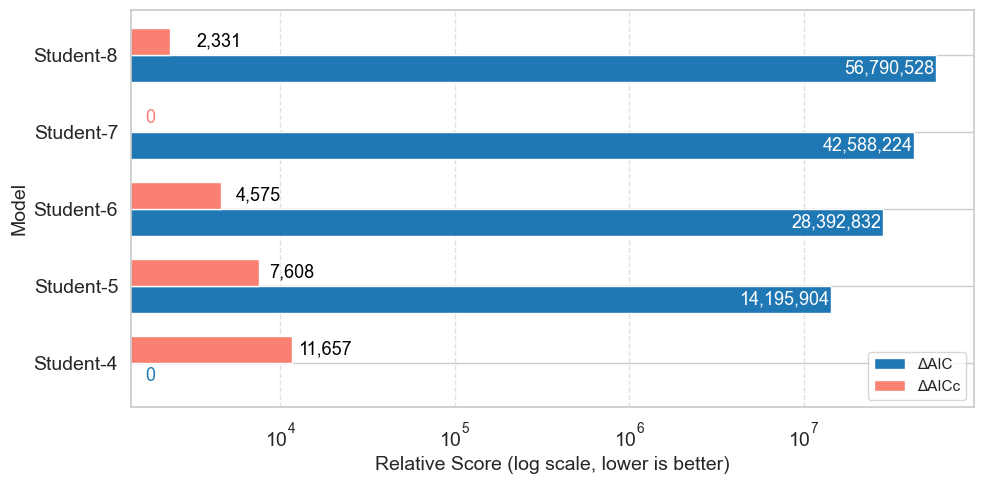

In [64]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
bar_width = 0.35
indices = np.arange(len(df))

# Colors
# color_aic = "salmon"
# color_aicc = "teal"
color_aic = "tab:blue"
color_aicc = "salmon"

# Plot bars
plt.barh(indices, df["Delta_AIC"], bar_width, label="ΔAIC", color=color_aic)
plt.barh(indices + bar_width, df["Delta_AICc"], bar_width, label="ΔAICc", color=color_aicc)

# Log scale after plotting
plt.xscale("log")
plt.grid(True, axis="x", linestyle="--", alpha=0.6)

# Grab current axes and x-limits
ax = plt.gca()
xmin, xmax = ax.get_xlim()
zero_x = xmin * 1.2  # place zero a bit to the right of visible edge

# Annotate values
for i, (aic, aicc) in enumerate(zip(df["Delta_AIC"], df["Delta_AICc"])):
    # ΔAIC
    if aic == 0:
        ax.text(zero_x, i, "0", va="center", ha="left", fontsize=13, color=color_aic)
    elif aic < 1e5:
        ax.text(aic + 1000, i, f"{int(aic):,}", va="center", ha="left", fontsize=13, color="black")
    else:
        ax.text(aic * 0.98, i, f"{int(aic):,}", va="center", ha="right", fontsize=13, color="white")

    # ΔAICc
    if aicc == 0:
        ax.text(zero_x, i + bar_width, "0", va="center", ha="left", fontsize=13, color=color_aicc)
    elif aicc < 1e5:
        ax.text(aicc + 1000, i + bar_width, f"{int(aicc):,}", va="center", ha="left", fontsize=13, color="black")
    else:
        ax.text(aicc * 0.98, i + bar_width, f"{int(aicc):,}", va="center", ha="right", fontsize=13, color="white")

# Labels and final touches
plt.yticks(indices + bar_width / 2, df["Model"])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Relative Score (log scale, lower is better)", fontsize=14)
plt.ylabel("Model", fontsize=14)
# plt.title("ΔAIC and ΔAICc")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("delta_aic_zero.pdf", dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()


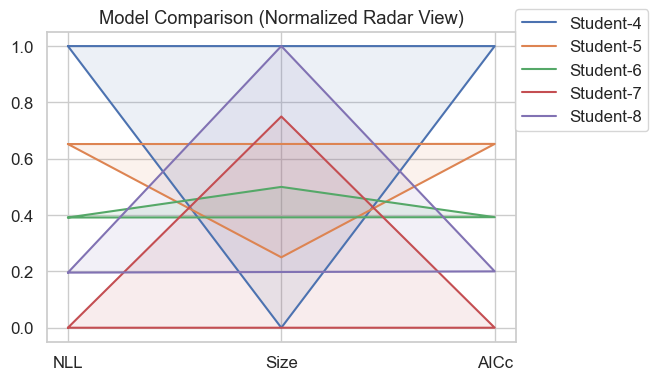

In [32]:
from math import pi

# Normalize values [0, 1]
normalized = df.copy()
for col in ["NLL_avg", "Params_M", "AICc"]:
    normalized[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

# Setup for radar plot
labels = ["NLL", "Size", "AICc"]
angles = [n / float(len(labels)) * 2 * pi for n in range(len(labels))]
angles += angles[:1]  # complete loop

plt.figure(figsize=(7, 4))
for i, row in normalized.iterrows():
    values = [row["NLL_avg"], row["Params_M"], row["AICc"]]
    values += values[:1]
    plt.plot(angles, values, linewidth=1.5, linestyle='solid', label=row["Model"])
    plt.fill(angles, values, alpha=0.1)

plt.xticks(angles[:-1], labels)
plt.title("Model Comparison (Normalized Radar View)")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.savefig("aicc_radar_chart.pdf", dpi=600)
plt.show()


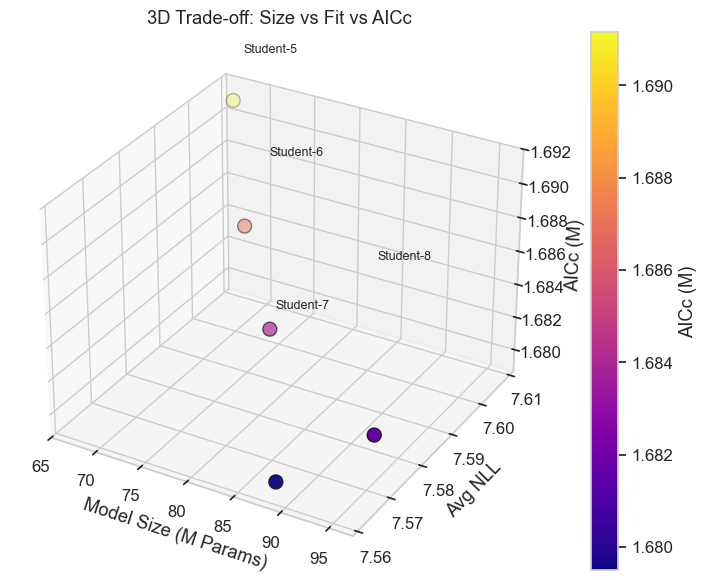

In [34]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

# Values
x = df["Params_M"]
y = df["NLL_avg"]
z = df["AICc"] / 1e6

# Plot
sc = ax.scatter(x, y, z, c=z, cmap='plasma', s=100, edgecolor='k', depthshade=True)
for i, label in enumerate(df["Model"]):
    ax.text(x[i], y[i], z[i]+0.01, label, fontsize=9)

ax.set_xlabel("Model Size (M Params)")
ax.set_ylabel("Avg NLL")
ax.set_zlabel("AICc (M)")
ax.set_title("3D Trade-off: Size vs Fit vs AICc")
fig.colorbar(sc, label="AICc (M)")
plt.tight_layout()
plt.savefig("aicc_3d_tradeoff.pdf", dpi=600)
plt.show()


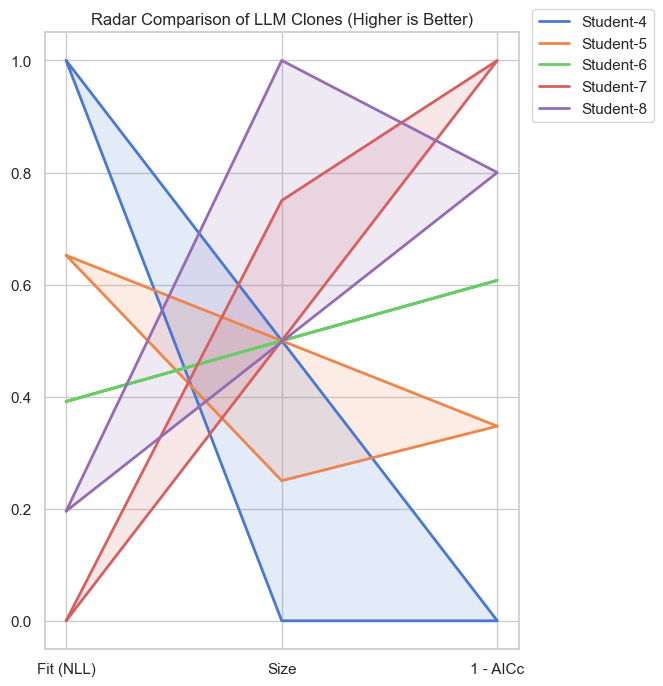

In [36]:
# Invert AICc (so higher = better)
df["AICc_score"] = df["AICc"].max() - df["AICc"]
radar_data = df[["Model", "NLL_avg", "Params_M", "AICc_score"]].copy()

# Normalize to [0, 1]
for col in ["NLL_avg", "Params_M", "AICc_score"]:
    radar_data[col] = (radar_data[col] - radar_data[col].min()) / (radar_data[col].max() - radar_data[col].min())

# Radar setup
labels = ["Fit (NLL)", "Size", "1 - AICc"]
angles = [n / float(len(labels)) * 2 * pi for n in range(len(labels))]
angles += angles[:1]

plt.figure(figsize=(7, 7))
for i, row in radar_data.iterrows():
    values = [row["NLL_avg"], row["Params_M"], row["AICc_score"]]
    values += values[:1]
    plt.plot(angles, values, linewidth=2, label=row["Model"])
    plt.fill(angles, values, alpha=0.15)

plt.xticks(angles[:-1], labels)
plt.title("Radar Comparison of LLM Clones (Higher is Better)")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.05))
plt.tight_layout()
plt.savefig("enhanced_radar_aicc.pdf", dpi=600)
plt.show()


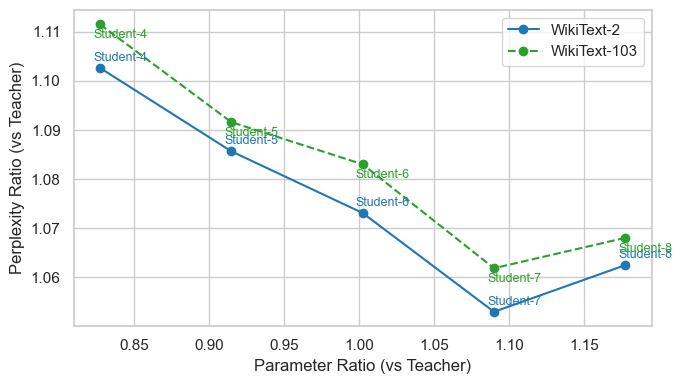

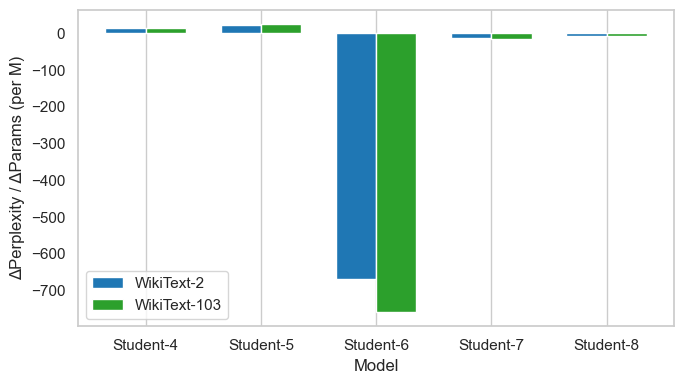

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn style
sns.set(style="whitegrid", context="notebook", palette="muted")

# Data
models = ["Student-4", "Student-5", "Student-6", "Student-7", "Student-8"]
params = [67.0, 74.1, 81.2, 88.3, 95.4]
ppl_wiki2 = [2013.4706, 1982.4438, 1959.4965, 1922.7330, 1940.0923]
ppl_wiki103 = [2029.6671, 1993.3018, 1977.6177, 1938.9505, 1950.2524]
teacher_ppl = 1826.0000
teacher_params = 81.0

# Derived values
ppl_ratio_wiki2 = [p / teacher_ppl for p in ppl_wiki2]
ppl_ratio_wiki103 = [p / teacher_ppl for p in ppl_wiki103]
param_ratio = [p / teacher_params for p in params]

# === PLOT 1: Normalized Perplexity vs Params ===
plt.figure(figsize=(7, 4))
plt.plot(param_ratio, ppl_ratio_wiki2, marker='o', linestyle='-', label="WikiText-2", color='tab:blue')
plt.plot(param_ratio, ppl_ratio_wiki103, marker='o', linestyle='--', label="WikiText-103", color='tab:green')
for i, model in enumerate(models):
    plt.annotate(model, (param_ratio[i], ppl_ratio_wiki2[i]), textcoords="offset points", xytext=(-5, 5), fontsize=9, color='tab:blue')
    plt.annotate(model, (param_ratio[i], ppl_ratio_wiki103[i]), textcoords="offset points", xytext=(-5, -10), fontsize=9, color='tab:green')
plt.xlabel("Parameter Ratio (vs Teacher)")
plt.ylabel("Perplexity Ratio (vs Teacher)")
# plt.title("Normalized Perplexity vs Normalized Model Size")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("normalized_performance_vs_size.png", dpi=600, bbox_inches='tight')
plt.show()

# === PLOT 2: Perplexity Increase per Param Saved ===
delta_ppl_wiki2 = [p - teacher_ppl for p in ppl_wiki2]
delta_ppl_wiki103 = [p - teacher_ppl for p in ppl_wiki103]
delta_params = [teacher_params - p for p in params]
efficiency_wiki2 = [dp / dparam for dp, dparam in zip(delta_ppl_wiki2, delta_params)]
efficiency_wiki103 = [dp / dparam for dp, dparam in zip(delta_ppl_wiki103, delta_params)]

bar_width = 0.35
x = range(len(models))

plt.figure(figsize=(7, 4))
plt.bar(x, efficiency_wiki2, width=bar_width, label="WikiText-2", color='tab:blue')
plt.bar([i + bar_width for i in x], efficiency_wiki103, width=bar_width, label="WikiText-103", color='tab:green')
plt.xticks([i + bar_width / 2 for i in x], models)
plt.xlabel("Model")
plt.ylabel("ΔPerplexity / ΔParams (per M)")
# plt.title("Perplexity Increase per Million Params Reduced")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("perplexity_efficiency_tradeoff.png", dpi=600, bbox_inches='tight')
plt.show()


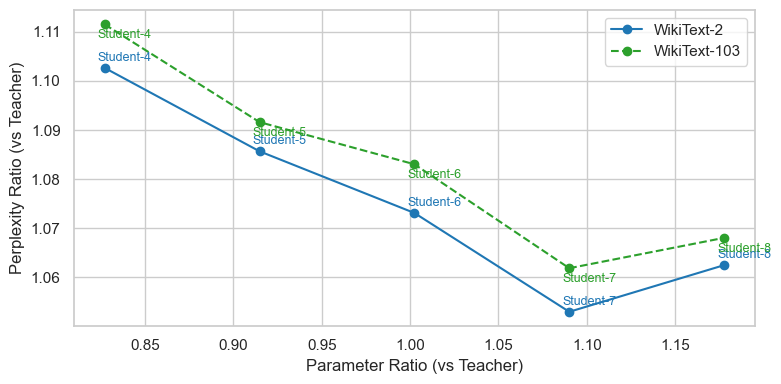

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn style
sns.set(style="whitegrid", context="notebook", palette="muted")

# Data
models = ["Student-4", "Student-5", "Student-6", "Student-7", "Student-8"]
params = [67.0, 74.1, 81.2, 88.3, 95.4]
ppl_wiki2 = [2013.4706, 1982.4438, 1959.4965, 1922.7330, 1940.0923]
ppl_wiki103 = [2029.6671, 1993.3018, 1977.6177, 1938.9505, 1950.2524]
teacher_ppl = 1826.0000
teacher_params = 81.0

# Derived values
ppl_ratio_wiki2 = [p / teacher_ppl for p in ppl_wiki2]
ppl_ratio_wiki103 = [p / teacher_ppl for p in ppl_wiki103]
param_ratio = [p / teacher_params for p in params]

# === PLOT 1: Normalized Perplexity vs Params ===
plt.figure(figsize=(8, 4))
plt.plot(param_ratio, ppl_ratio_wiki2, marker='o', linestyle='-', label="WikiText-2", color='tab:blue')
plt.plot(param_ratio, ppl_ratio_wiki103, marker='o', linestyle='--', label="WikiText-103", color='tab:green')
for i, model in enumerate(models):
    plt.annotate(model, (param_ratio[i], ppl_ratio_wiki2[i]), textcoords="offset points", xytext=(-5, 5), fontsize=9, color='tab:blue')
    plt.annotate(model, (param_ratio[i], ppl_ratio_wiki103[i]), textcoords="offset points", xytext=(-5, -10), fontsize=9, color='tab:green')
plt.xlabel("Parameter Ratio (vs Teacher)")
plt.ylabel("Perplexity Ratio (vs Teacher)")
# plt.title("Normalized Perplexity vs Normalized Model Size")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("normalized_performance_vs_size.pdf", dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()


Model  Params (M)  ΔParams (M)  ΔPPL Wiki-2  ΔPPL Wiki-103  \
0  Student-4        67.0         14.0     187.4706       203.6671   
1  Student-5        74.1          6.9     156.4438       167.3018   
2  Student-6        81.2         -0.2     133.4965       151.6177   
3  Student-7        88.3         -7.3      96.7330       112.9505   
4  Student-8        95.4        -14.4     114.0923       124.2524   

   ΔPPL/ΔParam W-2  ΔPPL/ΔParam W-103  
0        13.390757          14.547650  
1        22.673014          24.246638  
2      -667.482500        -758.088500  
3       -13.251096         -15.472671  
4        -7.923076          -8.628639

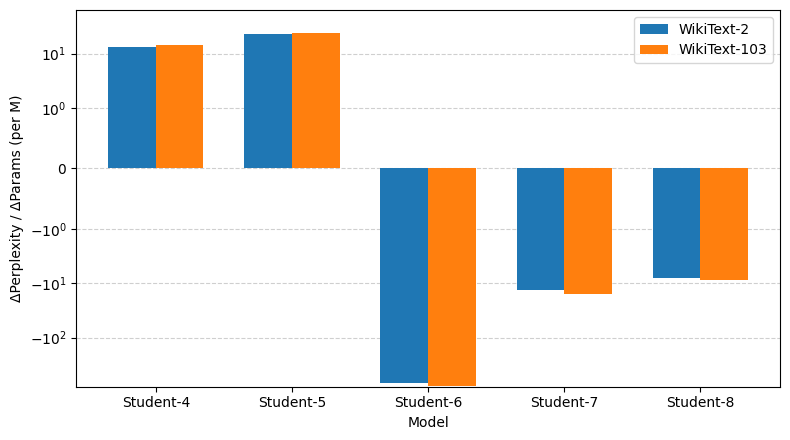

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display   # <‑‑ built‑in in Colab/Jupyter

# --- data --------------------------------------------------
models = ["Student-4", "Student-5", "Student-6", "Student-7", "Student-8"]
params = np.array([67.0, 74.1, 81.2, 88.3, 95.4])
ppl_wiki2  = np.array([2013.4706, 1982.4438, 1959.4965, 1922.7330, 1940.0923])
ppl_wiki103= np.array([2029.6671, 1993.3018, 1977.6177, 1938.9505, 1950.2524])

teacher_ppl, teacher_param = 1826.0, 81.0

# --- calculations -----------------------------------------
delta_ppl_wiki2   = ppl_wiki2  - teacher_ppl
delta_ppl_wiki103 = ppl_wiki103 - teacher_ppl
delta_params      = teacher_param - params            # +ve ⇒ params saved

efficiency_wiki2   = delta_ppl_wiki2   / delta_params
efficiency_wiki103 = delta_ppl_wiki103 / delta_params

df = pd.DataFrame({
    "Model": models,
    "Params (M)": params,
    "ΔParams (M)": delta_params,
    "ΔPPL Wiki-2":  delta_ppl_wiki2,
    "ΔPPL Wiki-103":delta_ppl_wiki103,
    "ΔPPL/ΔParam W-2":  efficiency_wiki2,
    "ΔPPL/ΔParam W-103": efficiency_wiki103,
})

display(df)        # use this instead of ace_tools.display_dataframe_to_user

# --- bar plot (symlog y‑axis) ------------------------------
bar_width = 0.35
x = np.arange(len(models))

plt.figure(figsize=(8, 4.5))
plt.gca().set_axisbelow(True)
plt.bar(x,            efficiency_wiki2,  bar_width, label="WikiText-2")
plt.bar(x+bar_width,  efficiency_wiki103,bar_width, label="WikiText-103")

plt.xticks(x + bar_width/2, models)
plt.xlabel("Model")
plt.ylabel("ΔPerplexity / ΔParams (per M)")
plt.yscale("symlog", linthresh=1)
plt.grid(axis='y', which='both', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("perplexity_efficiency_tradeoff_logScale.pdf", dpi=800, bbox_inches='tight')
plt.show()


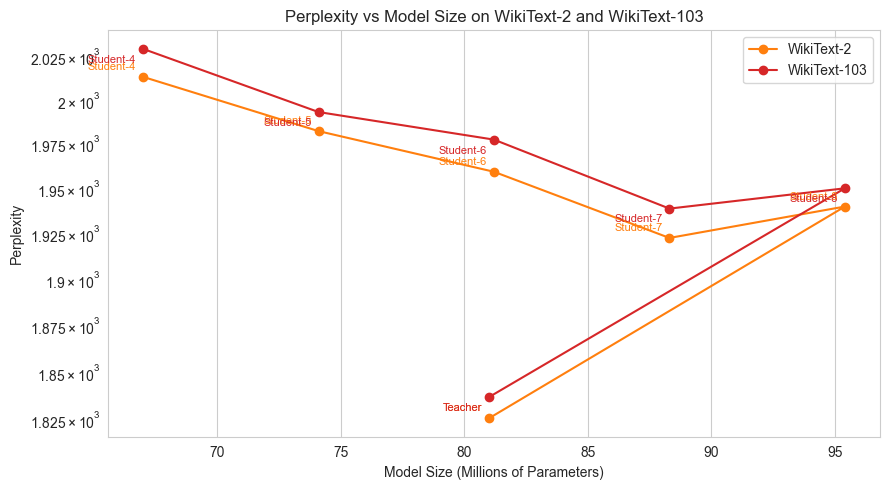

In [15]:
import matplotlib.pyplot as plt

# Data
models = ["Student-4", "Student-5", "Student-6", "Student-7", "Student-8", "Teacher"]
params = [67.0, 74.1, 81.2, 88.3, 95.4, 81.0]
ppl_wiki2 = [2013.4706, 1982.4438, 1959.4965, 1922.7330, 1940.0923, 1826.0000]
ppl_wiki103 = [2029.6671, 1993.3018, 1977.6177, 1938.9505, 1950.2524, 1837.1142]

# Plot
plt.figure(figsize=(9, 5))
plt.plot(params, ppl_wiki2, marker='o', linestyle='-', label='WikiText-2', color='tab:orange')
plt.plot(params, ppl_wiki103, marker='o', linestyle='-', label='WikiText-103', color='tab:red')

# Labels and title
plt.xlabel("Model Size (Millions of Parameters)")
plt.ylabel("Perplexity")
plt.title("Perplexity vs Model Size on WikiText-2 and WikiText-103")
plt.legend()
plt.grid(True)
plt.yscale('log')  # Optional: log scale to match visual trend

# Annotate model names
for i, model in enumerate(models):
    plt.annotate(model, (params[i], ppl_wiki2[i]), textcoords="offset points", xytext=(-5,5), ha='right', fontsize=8, color='tab:orange')
    plt.annotate(model, (params[i], ppl_wiki103[i]), textcoords="offset points", xytext=(-5,-10), ha='right', fontsize=8, color='tab:red')

plt.tight_layout()
plt.show()


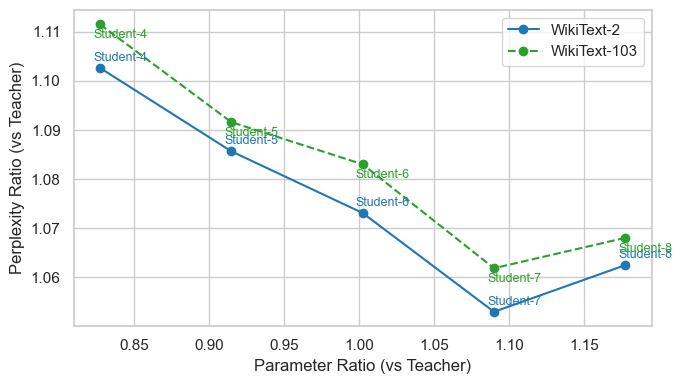

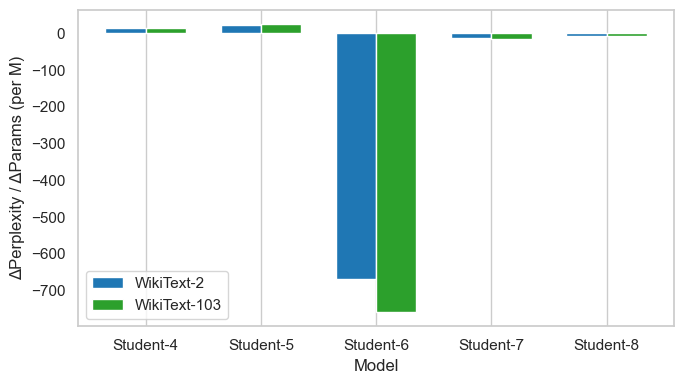

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use seaborn style
sns.set(style="whitegrid", context="notebook", palette="muted")

# Data
models = ["Student-4", "Student-5", "Student-6", "Student-7", "Student-8"]
params = [67.0, 74.1, 81.2, 88.3, 95.4]
ppl_wiki2 = [2013.4706, 1982.4438, 1959.4965, 1922.7330, 1940.0923]
ppl_wiki103 = [2029.6671, 1993.3018, 1977.6177, 1938.9505, 1950.2524]
teacher_ppl = 1826.0000
teacher_params = 81.0

# Derived values
ppl_ratio_wiki2 = [p / teacher_ppl for p in ppl_wiki2]
ppl_ratio_wiki103 = [p / teacher_ppl for p in ppl_wiki103]
param_ratio = [p / teacher_params for p in params]

# === PLOT 1: Normalized Perplexity vs Params ===
plt.figure(figsize=(7, 4))
plt.plot(param_ratio, ppl_ratio_wiki2, marker='o', linestyle='-', label="WikiText-2", color='tab:blue')
plt.plot(param_ratio, ppl_ratio_wiki103, marker='o', linestyle='--', label="WikiText-103", color='tab:green')
for i, model in enumerate(models):
    plt.annotate(model, (param_ratio[i], ppl_ratio_wiki2[i]), textcoords="offset points", xytext=(-5, 5), fontsize=9, color='tab:blue')
    plt.annotate(model, (param_ratio[i], ppl_ratio_wiki103[i]), textcoords="offset points", xytext=(-5, -10), fontsize=9, color='tab:green')
plt.xlabel("Parameter Ratio (vs Teacher)")
plt.ylabel("Perplexity Ratio (vs Teacher)")
# plt.title("Normalized Perplexity vs Normalized Model Size")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("normalized_performance_vs_size.png", dpi=600, bbox_inches='tight')
plt.show()

# === PLOT 2: Perplexity Increase per Param Saved ===
delta_ppl_wiki2 = [p - teacher_ppl for p in ppl_wiki2]
delta_ppl_wiki103 = [p - teacher_ppl for p in ppl_wiki103]
delta_params = [teacher_params - p for p in params]
efficiency_wiki2 = [dp / dparam for dp, dparam in zip(delta_ppl_wiki2, delta_params)]
efficiency_wiki103 = [dp / dparam for dp, dparam in zip(delta_ppl_wiki103, delta_params)]

bar_width = 0.35
x = range(len(models))

plt.figure(figsize=(7, 4))
plt.bar(x, efficiency_wiki2, width=bar_width, label="WikiText-2", color='tab:blue')
plt.bar([i + bar_width for i in x], efficiency_wiki103, width=bar_width, label="WikiText-103", color='tab:green')
plt.xticks([i + bar_width / 2 for i in x], models)
plt.xlabel("Model")
plt.ylabel("ΔPerplexity / ΔParams (per M)")
# plt.title("Perplexity Increase per Million Params Reduced")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("perplexity_efficiency_tradeoff.png", dpi=600, bbox_inches='tight')
plt.show()
